In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import sys
import glob
import os
import time 
import xesmf as xe
import scipy
from scipy import stats
from functools import partial
import yaml
import sys
import matplotlib.pyplot as plt
import proplot as pplt

from WWE_diag_tools import (
    land_mask_using_etopo,
    regridder_model2obs,
    nharm,
    calc_raw_and_smth_annual_cycle,
    isolate_WWEs,
    WWE_characteristics,
    WWE_statistics, #We don't need to do the statistics to make the likelihood by longitude plot
    find_WWE_time_lon)

In [12]:
def _preprocess(x, lon_bnds, lat_bnds):
    return x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds))

def find_WWEs_and_characteristics(in_data = None, tauu_thresh = 0.04, mintime = 5, minlons = 10,
                                 xminmax = (3, 3), yminmax = (3, 3), minmax_dur_bins = (5, 27),
                                 dur_bin_space = 2, minmax_IWW_bins = (1, 42), IWW_bin_space = 4,
                                 xtend_past_lon = 140):
    '''
    This function call the following functions within WWE_diag_tools.py
    - isolate_WWEs
        - find_nearby_wwes_merge
        - renumber_wwes
    - WWE_chracteristics
    - WWE_statistics
    - find_WWE_time_lon
    '''
    start_time = time.time()
    
    # 2) Find WWEs
    #The isolate_WWEs function uses the find_nearby_wwes_merge, renumber_wwes functions 
    WWE_labels, WWE_mask = isolate_WWEs(data = in_data, tauu_thresh = tauu_thresh, mintime = mintime, 
                                        minlons = minlons, xmin = xminmax[0], xmax = xminmax[1], 
                                        ymin = yminmax[0], ymax = yminmax[1], xtend_past_lon = xtend_past_lon)

    # 3) Find characteristics (i.e., duration, zonal extent, integrated wind work sum and mean) of each WWE
    #Uses WWE_characteristics function
    duration, zonal_extent, IWW, tauu_mean = WWE_characteristics(wwe_labels = WWE_labels, data = in_data)
    
    # 4) Compute statistics of WWE characteristics 
    #Uses WWE_statistics function
        #Histograms binned by duration
    dur_count, dur_freq, IWWmean_conddur_hist, zonalmean_conddur_hist, \
    IWWstd_conddur_hist, zonalstd_conddur_hist, bins, binnum_dur = \
    WWE_statistics(var2bin = duration, cond_var1 = IWW, cond_var2 = zonal_extent,
                   min_bin = minmax_dur_bins[0], max_bin = minmax_dur_bins[1], 
                   bin_space = dur_bin_space)

    df_conddur = dur_count - 1

        #Histograms binned by IWW
    IWW_count, IWW_freq, durmean_condIWW_hist, zonalmean_condIWW_hist, \
    durstd_condIWW_hist, zonalstd_condIWW_hist, bin_edges, binnum_IWW  = \
    WWE_statistics(var2bin = IWW, cond_var1 = duration, cond_var2 = zonal_extent,
                   min_bin = minmax_IWW_bins[0], max_bin = minmax_IWW_bins[1], 
                   bin_space = IWW_bin_space)

    df_condIWW = IWW_count - 1

    # 5) Find central, min, and max time and longitude of each WWE
    #Uses find_WWE_time_lon function
    tauu_time   = in_data["time"]
    tauu_lon    = in_data["lon"]
    lon_array   = np.asarray(tauu_lon)
       
    center_lon_vals, center_time_vals, min_times, max_times, min_lons, max_lons \
    = find_WWE_time_lon(data = in_data, wwe_labels = WWE_labels, 
                         lon = lon_array, time_array = tauu_time)

    print("--- %s seconds to compute characteristics---" % (time.time() - start_time))
    
    return duration, IWW, zonal_extent, tauu_mean, WWE_labels, WWE_mask, center_lon_vals, \
           center_time_vals, min_times, max_times, min_lons, max_lons, \
           lon_array, tauu_time, dur_count, dur_freq, IWWmean_conddur_hist, \
           zonalmean_conddur_hist, IWWstd_conddur_hist, zonalstd_conddur_hist, bins, binnum_dur, \
           IWW_count, IWW_freq, durmean_condIWW_hist, zonalmean_condIWW_hist, durstd_condIWW_hist, \
           zonalstd_condIWW_hist, bin_edges, binnum_IWW

def save_filtered_tauu_WWEchar(WWE_labels = None, tauu_anom = None, duration = None, IWW = None,
                               zonal_extent = None,tauu_filt_mean = None, tauu_abs_mean = None, 
                               center_lon_vals = None, center_time_vals = None, min_lon_vals = None, 
                               max_lon_vals = None, min_time_vals = None, max_time_vals = None,
                               lon_array = None, tauu_time = None, save_name = '',
                               filt_descrip = '120-day HP filtered'):
    
    uniq_WWE_labels = np.unique(WWE_labels)[1:]
    #reference_time  = pd.Timestamp('1970-01-01T00:00:00Z')

    data_vars = dict(
        wwe_labels    =(['time', 'lon'], WWE_labels.squeeze(), dict(units='None', long_name='Unique label for each WWE')),
        filtered_tauu =(['time', 'lon'], tauu_anom.squeeze(), dict(units='Pa', long_name = 'Mean ' + filt_descrip + ' zonal wind stress')),
        tauu_filt_mean=(['events'], tauu_filt_mean, dict(units='Pa', long_name = 'Mean ' + filt_descrip + ' zonal wind stress per WWE')),
        tauu_abs_mean =(['events'], tauu_abs_mean, dict(units='Pa', long_name = 'Mean absolute/unfiltered zonal wind stress per WWE')),
        duration      =(['events'], duration, dict(units='Days', long_name = 'duration of each WWE')),
        IWW_vals      =(['events'], IWW, dict(units='Pa', long_name='Integrated wind work for each WWE')),
        zonal_extent  =(['events'], zonal_extent, dict(units='Degrees', long_name = 'Longitudinal extent of each WWE')),
        center_lons   =(['events'], center_lon_vals, dict(units='Degrees', long_name = 'Mass-weighted center longitude for each WWE')),
        min_lons      =(['events'], min_lon_vals, dict(units='Degrees', long_name = 'Min longitude for each WWE')),
        max_lons      =(['events'], max_lon_vals, dict(units='Degrees', long_name = 'Max longitude for each WWE')),
        min_times     =(['events'], min_time_vals),
        max_times     =(['events'], max_time_vals),
        center_times  =(['events'], center_time_vals)
    )

    ds = xr.Dataset(data_vars = data_vars,
                    coords=dict(
                        events= (["events"], uniq_WWE_labels),
                        lon   = lon_array,
                        time  = tauu_time,
                    ),
                    attrs=dict(description= filt_descrip + " zonal wind stress and WWE characteristics. Generated using MDTF POD WWE diagnostic")
                   )

    ds.to_netcdf(save_name + '.nc')
    
    return ds

def save_WWE_binned_stats(dur_freq = None, IWWmean_conddur_hist = None, zonalmean_conddur_hist = None, 
                          IWWstd_conddur_hist = None, zonalstd_conddur_hist = None, IWW_freq = None, 
                          durmean_condIWW_hist = None, zonalstd_condIWW_hist = None,
                          bins = None, bin_edges = None, save_name = ''):

    data_vars = dict(
        dur_freq=(["dur_bins"],             dur_freq,              dict(units='percent',long_name='Frequency of duration for WWEs')),
        IWWmean_perdur_hist=(["dur_bins"],  IWWmean_conddur_hist,   dict(units='Pa',     long_name='mean integrated wind work per duration bin')),
        zonalmean_perdur_hist=(["dur_bins"],zonalmean_conddur_hist,dict(units='Degrees',long_name='mean zonal extent per duration bin')),
        IWWstd_perdur_hist=(["dur_bins"],   IWWstd_conddur_hist,   dict(units='Pa',     long_name='Standard deviation of integrated wind work per duration bin')),
        zonalstd_perdur_hist=(["dur_bins"], zonalstd_conddur_hist, dict(units='Degrees',long_name='Standard deviation zonal extent per duration bin')),
        IWW_freq=(["IWW_bins"],             IWW_freq,              dict(units='percent',long_name='Frequency of IWW values for WWEs')),  
        durmean_perIWW_hist=(["IWW_bins"],  durmean_condIWW_hist,  dict(units='Days',   long_name='mean duration per IWW bin')),
        zonalmean_perIWW_hist=(["IWW_bins"],zonalmean_condIWW_hist,dict(units='Degrees',long_name='mean zonal extent per IWW bin')),
        durstd_perIWW_hist=(["IWW_bins"],   durstd_condIWW_hist,   dict(units='Days',   long_name='Standard deviation duration per IWW bin')),
        zonalstd_perIWW_hist=(["IWW_bins"], zonalstd_condIWW_hist, dict(units='Degrees',long_name='Standard deviation zonal extent per IWW bin')), 
    )

    ds2save = xr.Dataset(
        data_vars=data_vars,
        coords=dict(dur_bins=(["dur_bins"], bins[:-1]),
                    IWW_bins=(["IWW_bins"], bin_edges[:-1])),
        attrs=dict(description="WWE binned statistics")
    )


    ds2save.to_netcdf(save_name + "_WWE_binned_stats.nc")
    
    return ds2save


def events_per_lon(in_da = None):
    
    nevents    = np.unique(in_da)[1:].size #Don't count zero
    event_nums = np.unique(in_da)[1:]
    
    event_lon_mask = np.zeros(nevents*in_da.lon.size).reshape(nevents, in_da.lon.size)
    var_shape_list = in_da.shape

    for ievent in range(nevents):
        lon_axis  = var_shape_list.index(in_da.lon.shape[0])
        temp_lons = np.zeros(in_da.lon.size)    
        w         = np.where(in_da == event_nums[ievent])
        uniq_wlons= np.unique(w[lon_axis])
        temp_lons[uniq_wlons] = 1
        event_lon_mask[ievent] = temp_lons
        
    count_event_lons = np.sum(event_lon_mask, axis = 0)
    
    return count_event_lons, nevents

def compute_plot_WWE_likelihood_per_lon(WWE_labels = None, lons = None, times = None,
                                        obs_WWE_labels = None, ref_aspect = (3, 2), model_name = '', 
                                        fig_width = 4, save_name = '', do_span = True, do_share = True):
    
    obs_count_event_lons, n_events = events_per_lon(in_da = obs_WWE_labels)

    obs_pd_struc = pd.DataFrame(obs_count_event_lons, columns = pd.Index(['TropFlux']),
                                    index = pd.Index(obs_WWE_labels.lon, name = 'Longitude'))
         
    fig, ax = pplt.subplots(figwidth = fig_width, refaspect=ref_aspect)
        
    WWE_labels_da = xr.DataArray(data=WWE_labels, dims = ['time', 'lon'], 
                                 coords=dict(
                                     lon=(['lon'], lons),
                                     time=times,),
                                 attrs=dict(description="WWE labels", units = 'N/A',)
                                )
        
    count_all_event_lons, n_events = events_per_lon(in_da = WWE_labels_da)

    #Make into a panda structure for easier plotting
    pd_struc = pd.DataFrame(count_all_event_lons, columns = pd.Index([model_name]),
                            index = pd.Index(WWE_labels_da.lon, name = 'Longitude'))
        
    cb = ax.area(pd_struc/WWE_labels.time.size*100., label = model_name, alpha = 0.99)
    cb = ax.area(obs_pd_struc/obs_WWE_labels.time.size*100.,
                 alpha = 0.7, color ='gray', label = 'TropFlux')
                        
    ax.format(ylim = (0, 1.8), xlim = (110, 280), 
              title = model_name, titleloc = 'l')
    ax.legend(loc='ur', ncols = 1, prop={"size":7})
    
    ax2 = ax.twinx()
    ytick_vals = ax.get_yticks()
    ytick_vals[-1] = 1.8
    label = np.around(100/ytick_vals, decimals = 1)
    label = ['inf', '200.0', '100.0', '66.7', '']
    ax2.set_yticks(ytick_vals)
    ax2.set_yticklabels(label, fontsize = 10)
    ax2.set_xlabel('Longitude', fontsize = 10)
    ax2.set_ylabel('Rate of return (days)')
                
    ax.format(titlesize = 10, fontsize = 10, xlabel = 'Longitude',
              ylabel = 'Probability per day (%)')
        
    fig.save('Likelihood_WWEpoint_per_longitude_'+save_name+'.png')
        
    return obs_count_event_lons, cb

def plot_model_Hovmollers_by_year(data = None, wwe_mask = None, lon_vals = None,
                                  tauu_time = None, savename = '',
                                  first_year = '', last_year = ''):
    
    year_array = np.unique(tauu_time.dt.year)
    nyears     = np.unique(tauu_time.dt.year).size

    fig, ax = plt.subplots(ncols=5, nrows=4, figsize = (15, 16), sharex = True, sharey = True) 
    axlist = ax.flatten()
    shade_choice     = 'bwr'
    levs             = np.linspace(-0.1, 0.1, 21)

    kwargs = {'fontsize':12}
    ####################################################################################
    #Loop through each year to make a Hovmoller panel of filtered zonal wind stress
    #for each year overlapped with WWE blobs
    ####################################################################################
    for iyear in range(20):
        wiyear = np.where((np.asarray(tauu_time.dt.year) == year_array[iyear]))
        
        ########################################################################           
        #Plot details
        ########################################################################=
        cf = axlist[iyear].contourf(np.asarray(lon_vals), np.arange(0, tauu_time[wiyear[0]].size),
                                    np.asarray(data[wiyear[0], :]), levels = levs, 
                                    cmap = shade_choice, extend = 'both')

        cl = axlist[iyear].contour(np.asarray(lon_vals), np.arange(0, tauu_time[wiyear[0]].size),  
                                   wwe_mask[wiyear[0], :], cmap = 'binary', linewidths = 1)

        axlist[iyear].grid(alpha = 0.5)
        
        if iyear >=15 :axlist[iyear].set_xlabel('longitude', **kwargs)
        if iyear%5 == 0: axlist[iyear].set_ylabel('day of year', **kwargs)
        axlist[iyear].set_title(str(year_array[iyear]), fontsize=12, loc = 'left')
        axlist[iyear].tick_params(axis='y', labelsize=12)
        axlist[iyear].tick_params(axis='x', labelsize=12)
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

    cbar_ax = fig.add_axes([0.81, 0.35, 0.015, 0.3])
    cbar_ax.tick_params(labelsize=12)
    cb = plt.colorbar(cf, cax=cbar_ax)
    cb.set_label(label = '$\u03C4_x$ (N $m^{-2}$)', fontsize = 12)
    
    endof20yrs = str(int(first_year) + 19)
    plt.savefig(savename + first_year + '-' + endof20yrs + '.YearlyHovmollers.png', bbox_inches='tight')
    
    if year_array.size > 20:
        fig, ax = plt.subplots(ncols=5, nrows=4, figsize = (15, 16), sharex = True, sharey = True) 
        axlist = ax.flatten()

        for iyear in range(year_array.size - 20):
            wiyear = np.where((np.asarray(tauu_time.dt.year) == year_array[iyear + 20]))
                
            ####################################################################           
            #Plot details
            ########################################################################
            cf = axlist[iyear].contourf(np.asarray(lon_vals), np.arange(0, tauu_time[wiyear[0]].size),
                                    np.asarray(data[wiyear[0], :]), levels = levs, 
                                    cmap = shade_choice, extend = 'both')
            
            cl = axlist[iyear].contour(np.asarray(lon_vals), np.arange(0, tauu_time[wiyear[0]].size),  
                                       wwe_mask[wiyear[0], :], cmap = 'binary', linewidths = 1)

            axlist[iyear].grid(alpha = 0.5)
            
            if iyear >=15 :axlist[iyear].set_xlabel('longitude', **kwargs)
            if iyear%5 == 0: axlist[iyear].set_ylabel('day of year', **kwargs)
            axlist[iyear].set_title(str(year_array[iyear + 20]), fontsize=12, loc = 'left')
            axlist[iyear].tick_params(axis='y', labelsize=12)
            axlist[iyear].tick_params(axis='x', labelsize=12)
            plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

        cbar_ax = fig.add_axes([0.81, 0.35, 0.015, 0.3])
        cbar_ax.tick_params(labelsize=12)
        cb = plt.colorbar(cf, cax=cbar_ax)
        cb.set_label(label = '$\u03C4_x$ (N $m^{-2}$)', fontsize = 12)
        
        start2ndpage = str(int(first_year) + 20)
        plt.savefig(savename + start2ndpage + '-' + last_year + '.YearlyHovmollers.png', bbox_inches='tight')
    
    return cf

# ID WWEs

In [ ]:
print("\n=======================================")
print("BEGIN ID_WWEs.py ")
print("=======================================")

# Parse MDTF-set environment variables
print("*** Parse MDTF-set environment variables ...")
#*************************************************************************************
#***Ι DON'T KNOW WHERE THESE GET SET, A CONFIG FILE? THE CASE_INFO.YML FILE?******
#**** I think a lot of these variables end up coming from the case_env_file that the framework creates
#the case_env_file points to the csv file, which in turn points to the data files. Variables from the data files
#are then read in. See example_multicase.py

CASENAME = os.environ["CASENAME"]
STARTDATE= os.environ["startdate"]
ENDDATE  = os.environ["enddate"]
WK_DIR   = os.environ["WORK_DIR"]
OBS_DATA = os.environ["OBS_DATA"]

# Input and output files/directories
#MODEL FILES (I think these files go in the csv file, which is referred to in the CATALOG_FILE (i.e., a .json file) and CASE_ENVI_FILE)
#Model zonal wind stress (tauu) file
tauu_file     = os.environ["TAUU_FILE"] #'/Users/eriley/NOAA_POD/model_data/'+dir_name[imodel]+'/tauu/tauu*1.nc'

#Model Land fraction file
lf_dir     = os.environ["LANDFRAC_DIR"] #'/Users/eriley/NOAA_POD/model_data/sftlf_historical/'
lf_file    = lf_dir + 'sftlf_fx_'+dir_name[imodel]+'_historical_*.nc'

#OBSERVATION FILES:
#Observed topography
topo_file     = os.environ["TOPO_FILE"] #'/Users/eriley/etopo2.nc'

#file with lat-lon grid info for observations
obs_grid_file = os.environ["TROPFLX_GRID_FILE"] #'/Users/eriley/NOAA_POD/obs_data/TropFlux_10m_windspeed/ws_tropflux_1d_2018.nc'
    
data_dir      = f"{WK_DIR}/model/netCDF"
plot_dir      = f"{WK_DIR}/model/PS/"
obs_plot_dir  = f"{WK_DIR}/obs/PS/"
#*************************************************************************************
#Where are these written in the new framework using the intake catalog instead of the settings file?
# Parse POD-specific environment variables
print("*** Parsing POD-specific environment variables")
regrid_method_type = os.environ["REGRID_METHOD"]                             
obs_firstyr        = int(os.environ["OBS_FIRSTYR"])
obs_lastyr         = int(os.environ["OBS_LASTYR"])
min_lon            = float(os.environ["min_lon"])
max_lon            = float(os.environ["max_lon"])
min_lat            = float(os.environ["min_lat"])
max_lat            = float(os.environ["max_lat"])
anom_method        = os.environ["ANOM_METHOD"]
do_bp_filter       = True if anom_method == 'bandpass' else False
do_hp_filter       = True if anom_method == 'highpass' else False
do_anom            = True if anom_method == 'dailyanom' else False
 
static_thresh = bool(int(os.environ["STATIC_THRESH"]))
LP_cutoff     = 5   #removes signals shorter than this many days
HP_cutoff     = 120 #removes singlas longer than this many days
sigma_factor  = int(os.environ["SIGMA_FACTOR"])
if do_hp_filter is True:
    filter_descrip= str(HP_cutoff)+' HP filter for $\u03C4_x$ ' + str(min_lat) + ' - ' + str(max_lat)

if do_bp_filter is True:
    filter_descrip= str(LP_cutoff)+ '-' + str(HP_cutoff) +' BP filter for $\u03C4_x$ ' + str(min_lat) + ' - ' + str(max_lat) 

if do_anom is True:
    filter_descrip = 'Annual cycle romoved for $\u03C4_x$ ' + str(min_lat) + ' - ' + str(max_lat)

#Note these thresh_values are the static values used for 1sigma
#and 2sigma of the observations
if sigma_factor == 1:
    thresh_val = '02' 
    tauu_thresh2use = 0.02 
    
if sigma_factor == 2:
    thresh_val = '04' 
    tauu_thresh2use = 0.04

#Input and output files/directories
#Open the topography file
topo_ds               = xr.open_dataset(topo_file)
topo_ds.coords['lon'] = (topo_ds.coords['lon'] + 360) % 360
topo_ds               = topo_ds.sortby(topo_ds.lon)
trop_topo_ds          = topo_ds.sel(lat = slice(lat_bnds[1], lat_bnds[0]))
trop_topo_longrid, trop_topo_latgrid = np.meshgrid(trop_topo_ds.lon, trop_topo_ds.lat)
topo_longrid_1D       = trop_topo_longrid.reshape(trop_topo_ds.lon.size * trop_topo_ds.lat.size)
topo_latgrid_1D       = trop_topo_latgrid.reshape(trop_topo_ds.lon.size * trop_topo_ds.lat.size)
topo_data1D           = trop_topo_ds['btdata'].values.reshape(trop_topo_ds.lon.size * trop_topo_ds.lat.size)

#Open TropFlux wind speed file, so we have the TropFlux lat-lon information for regridding purposes 
obs_grid_ds   = xr.open_dataset(obs_grid_file)
obs_grid_ds   = obs_grid_ds.pad(longitude = 5).roll(longitude = 25, roll_coords = True)
obs_grid_ds   = obs_grid_ds.assign_coords(longitude = np.arange(0.5, 360.5))
obs_grid_ds   = obs_grid_ds.rename({'longitude': 'lon', 'latitude': 'lat'})

#*************************************************************************************
#***NEED TO FIGURE OUT WHAT TO DO WITH THIS LIST OF DIRECTORIES****
#completed models using land-sea mask with conservative regridding:
dir_name = ['AWI-ESM-1-1-LR', 'CanESM5', 'CESM2-FV2', 'CESM2-WACCM','CMCC-CM2-SR5', 'CMCC-CM2-HR4', 'CMCC-ESM2',
           'IPSL-CM6A-LR', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR-INCA', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 
           'CNRM-CM6-1', 'CNRM-ESM2-1', 'EC-Earth3', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'GFDL-CM4', 'GFDL-ESM4',
           'MIROC-ES2L', 'MIROC6', 'MIROC-ES2H', 'UKESM1-0-LL', 'NorESM2-MM', 'NorESM2-LM',
           'INM-CM4-8','INM-CM5-0']
#dir_name = ['CESM2', 'CESM2-WACCM-FV2'] #do separately because need to use tauu_regridder
dir_name = ['CNRM-CM6-1', 'CNRM-ESM2-1'] #['GFDL-CM4']
dir_name = ['MPI-ESM1-2-LR', 'NorESM2-MM', 'NorESM2-LM']
#*************************************************************************************

#Define lats to average tauu over and lon range to analyze
lat_lim = [min_lat, max_lat]
lon_lim = [min_lon, max_lon]

firstyr = int(STARTEDATE[0:4])
lastyr  = int(ENDDATE[0:4])

for imodel in range(len(dir_name)):
    print('working on: ' + dir_name[imodel])
        
    #When opening model output and preprocessing, only open latitude band that is slightly larger
    #than observation data set (i.e., TropFlux)
    lon_bnds, lat_bnds = (0, 360), (-32.5, 32.5)
    partial_func       = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)

    #Get zonal wind stress variable
    model_ds = xr.open_mfdataset(tauu_file, preprocess=partial_func)
    model_ds = model_ds.squeeze() #remove extra dimension as necessary
    #Find time of interest
    model_ds = model_ds.where((model_ds.time.dt.year >= firstyr) & 
                              (model_ds.time.dt.year <= lastyr), drop = True)
    
    var_list     = list(model_ds.keys())
    ret_val_tauu = 'tauu' in var_list
    ret_val_TAUU = 'TAUX' in var_list
    
    if ret_val_tauu is True: tauu_name = 'tauu'
    if ret_val_TAUU is True: tauu_name = 'TAUX' 
        
    #*********Will need to update what this shortname variable should be set to. 
    #I don't think the tauu_file[:-21] is correct, but may be ok
    shortname = tauu_file[0][:-21]
        
    ##################################################
    #Get land fraction information and mask out land
    ##################################################
    check_file = glob.glob(lf_file)
    
    if len(check_file) == 1:
        #***Will need to add a check for if the sftlf file exists, but the grid is different than the tauu variable
        #***For now, can only use sftlf file if the grid is the same as the tauu grid
        lf_ds  = xr.open_mfdataset(lf_file, preprocess=partial_func)
        masked_tauu = model_ds[tauu_name].where(lf_ds['sftlf'] < 10)

    #If the model does not have a sftlf file, then use etopo2.nc file to create land-sea mask
    if len(check_file) == 0:
        print('using observed etopo2.nc file to create land-sea mask')
        ls_mask = land_mask_using_etopo(ds = model_ds, topo_latgrid_1D = topo_latgrid_1D, 
                                        topo_longrid_1D = topo_longrid_1D,
                                        topo_data1D = topo_data1D, lf_cutoff = 10)
        masked_tauu = model_ds[tauu_name].where(ls_mask == 1)
        
    if len(check_file) > 1: 
        print('Error: Multiple land fraction (sftlf) files found. There should only be one!')
        print('Program will exit')
        sys.exit()
  
    tauu_ds = masked_tauu.to_dataset()

    #Create a mask variable for the tauu and ws dataset
    tauu_ds["mask"]       = xr.where(~np.isnan(tauu_ds[tauu_name].isel(time = 0)), 1, 0)
    obs_grid_ds["mask"]   = xr.where(~np.isnan(obs_grid_ds["ws"].isel(time = 0)), 1, 0)
    
    ##################################################
    #Regrid tauu to the observations
    ##################################################
    if tauu_ds.lat.size > 1:
        print('tauu_ds.lat.size > 1')
        regridder_tauu = regridder_model2obs(lon_vals = obs_grid_ds.lon.values, lat_vals = obs_grid_ds.lat.values,
                                             in_data = tauu_ds, type_name = regrid_method_type, isperiodic = True)
        re_model_var   = regridder_tauu(tauu_ds[tauu_name], skipna = True)
    else:
        print('tauu_ds.lat.size <= 1')
        re_model_var = tauu_ds.interp(lon = obs_grid_ds.lon)[tauu_name]
    
    ##################################################
    #Find region of interest
    ##################################################
    dr_region = ((re_model_var).where(
        (re_model_var.lat >= np.array(lat_lim).min()) &
        (re_model_var.lat <= np.array(lat_lim).max()) &
        (re_model_var.lon >= np.array(lon_lim).min()) &
        (re_model_var.lon <= np.array(lon_lim).max()),
        drop = True))
    
    ##################################################
    #Average over the latitudes
    ##################################################
    #The xarray mean function ignores the nans
    dr_region_latavg = dr_region.mean(dim = 'lat') 
    
    ###################################################################################
    #Check to see if westerly zonal wind stresses are recorded as positive or negative
    ###################################################################################
    mean_lon220p5 = np.array(np.mean(dr_region_latavg.sel(lon = 220.5)))
    print(mean_lon220p5)
    factor = -1 if mean_lon220p5 > 0 else 1 
    tauu   = dr_region_latavg * factor  
    tauu   = tauu[tauu_name]

    ##################################################
    #Compute and plot annual cycle
    ##################################################
    if do_anom is True:
        tauu_AC_ds   = calc_raw_and_smth_annual_cycle(raw_data = ds, factor = 1, 
                                                      arname = tauu_name, in_units = 'Nm-2')
        save_name = 'RawAndSmth_AnnualCycle_'+shortname
        
        #Save the tauu_data to a netcdf
        tauu_AC_ds.to_netcdf(save_name + '_AC_tauu_EQ_' +str(min_lon)+'to'+str(max_lon)+'.nc')
        
        #****NΕΕD TO FIGURE OUT HOW TO DO PROPLOT IN MDTF SOFTWARE PACKAGE
        #plot_annual_cycle(in_data = tauu_AC_ds['smthAC'], xax_name = 'lon', yax_name = 'dayofyear',
        #                  levs = np.linspace(-0.1, 0.1, 21), color_choice = 'coldhot', var_name = 'Taux',
        #                  save_name = 'SmthAC_'+shortname)

        tauu_anom = tauu.groupby('time.dayofyear')  - tauu_AC_ds['smthAC'] 

    #Filter tauu or find anomalies of tauu to use as input to find WWEs and their chracteristics
    #Various options
    # 1) Filter the data to intraseasonal timescale (5-90 days following Puy et al. 2016)
    # 2) High pass filter of 90 days
    # 3) Anomalies by removing annual cycle
    filt_data1 = filter_data(data = tauu, nweights = 201, a = LP_cutoff)
    filt_data2 = filter_data(data = tauu, nweights = 201, a = HP_cutoff)
    
    if do_bp_filter is True: 
        data2use        = filt_data1 - filt_data2
        obs_tauu_thresh = tauu_thresh2use
    if do_hp_filter is True: 
        data2use        = tauu - filt_data2
        obs_tauu_thresh = tauu_thresh2use
    if do_anom is True: 
        data2use        = tauu_anom
        obs_tauu_thresh = 0.05

    tauu_thresh2use = obs_tauu_thresh if static_thresh is True else np.round(data2use.std()*sigma_factor, decimals = 2)
    model_thresh = np.round(data2use.std()*sigma_factor, decimals = 2)
    print('model tauu thresh: ', model_thresh)
    print('tauu thresh: ', tauu_thresh2use) 
    
    #Find WWEs and their characteristics and compute statistics 
    duration, IWW, zonal_extent, tauu_mean, WWE_labels, center_lon_vals, \
    center_time_vals, min_times, max_times, min_lons, max_lons, \
    lon_array, tauu_time, dur_count, dur_freq, IWWmean_conddur_hist, \
    zonalmean_conddur_hist, IWWstd_conddur_hist, zonalstd_conddur_hist, bins, binnum_dur, \
    IWW_count, IWW_freq, durmean_condIWW_hist, zonalmean_condIWW_hist, durstd_condIWW_hist, \
    zonalstd_condIWW_hist, bin_edges, binnum_IWW = \
    find_WWEs_and_characteristics(in_data = data2use, tauu_thresh = tauu_thresh2use, mintime = 5, minlons = 10,
                                  xminmax = (3, 3), yminmax = (3, 3), minmax_dur_bins = (5, 27),
                                  dur_bin_space = 2, minmax_IWW_bins = (1, 42), IWW_bin_space = 4,
                                  xtend_past_lon = 140)
    
    
    durationB, zonal_extentB, tauu_sum, tauu_abs_mean = WWE_characteristics(wwe_labels = WWE_labels, data = tauu) #ds[tauu_name])

    ####################################################################
    # Save the WWE characteristics and statistics to a netcdf file
    ####################################################################   
    WWE_chars = save_filtered_tauu_WWEchar(WWE_labels = WWE_labels, tauu_anom = data2use, duration = duration, IWW = IWW,
                                           zonal_extent = zonal_extent, tauu_filt_mean = tauu_mean, tauu_abs_mean = tauu_abs_mean, 
                                           center_lon_vals = center_lon_vals, center_time_vals = center_time_vals, 
                                           min_lon_vals = min_lons, max_lon_vals = max_lons, min_time_vals = min_times, 
                                           max_time_vals = max_times, lon_array = lon_array, tauu_time = tauu_time, 
                                           save_name = f"{CASENAME}", filt_descrip = filter_descrip)
    
    WWE_stats = save_WWE_binned_stats(dur_freq = dur_freq, IWWmean_conddur_hist = IWWmean_conddur_hist, 
                                      zonalmean_conddur_hist = zonalmean_conddur_hist, 
                                      IWWstd_conddur_hist = IWWstd_conddur_hist, 
                                      zonalstd_conddur_hist = zonalstd_conddur_hist, 
                                      IWW_freq = IWW_freq, durmean_condIWW_hist = durmean_condIWW_hist, 
                                      zonalstd_condIWW_hist = zonalstd_condIWW_hist, 
                                      bins = bins, bin_edges = bin_edges, save_name = f"{CASENAME}")

---
## Get obs and model data

In [3]:
obs_folder_name = '120dayHPfilter_static0p04TauxThresh/'
obs_dir = '/Users/eriley/Desktop/my-notebook/NOAA_MDTF/netcdf_files/WWE_characteristics/' + obs_folder_name
  
obs_ds          = xr.open_mfdataset(obs_dir + 'taux.*')
obs_data        = obs_ds["filtered_taux"]
obs_time        = obs_ds["time"]
obs_wwe_labels  = obs_ds["wwe_labels"]
wwe_mask        = np.where(obs_wwe_labels > 0, 1, 0)
center_lon_vals = obs_ds["wwe_lons"]
center_time_vals= obs_ds["wwe_times"]
obs_lon_vals    = np.asarray(obs_ds["lon"])

year_array      = np.unique(obs_time.dt.year)

model_dir         = '/Users/eriley/Desktop/my-notebook/NOAA_MDTF/netcdf_files/WWE_characteristics/'
model_folder_name = '120dayHPfilter_static0p04TauxThresh/'
model_filename    = 'tauu_Eday_CESM2-FV2_historical_r1i1p1f1_gn.nc'

model_ds          = xr.open_mfdataset(model_dir + model_folder_name + model_filename)
model_data        = model_ds["filtered_taux"]
model_time        = model_ds["time"]
model_wwe_labels  = model_ds["wwe_labels"] 
model_lon_vals    = np.asarray(model_ds["lon"])

dirname  = '/Users/eriley/NOAA_POD/obs_data/'
filename = 'taux.1980-2018.2p5S-2p5N_avg.global.nc'
ws_file  = 'TropFlux_10m_windspeed/ws_tropflux_1d_2018.nc'
ws_ds    = xr.open_dataset(dirname + ws_file)
ws_ds    = ws_ds.pad(longitude = 5).roll(longitude = 25, roll_coords = True)
ws_ds    = ws_ds.assign_coords(longitude = np.arange(0.5, 360.5))
ws_ds    = ws_ds.rename({'longitude': 'lon', 'latitude': 'lat'})

ws_lat_vals = ws_ds.lat
ws_lon_vals = ws_ds.lon

## Plot Hovmollers and likelihood of WWE per longitude in obs vs. simulation

{}


/var/folders/bx/ck1jzpsn3t9flxhnk_53pkdc0001zx/T/ipykernel_90581/1219728350.py:181: RuntimeWarning: divide by zero encountered in divide
  label = np.around(100/ytick_vals, decimals = 1)


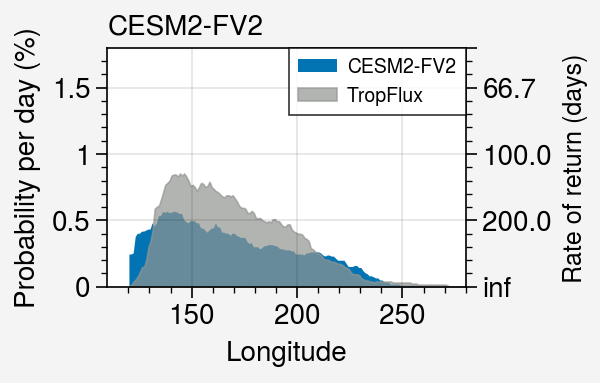

In [6]:
#Tested to make sure it works for the observations. I had to delete the save file lines b/c "CASENAME" is not defined
#plot_model_Hovmollers_by_year(data = obs_data, tauu_time = obs_time)

savename = '_MAM_ObsOverlaid_30models'
obs_count_event_lons = compute_plot_WWE_likelihood_per_lon(WWE_labels = model_wwe_labels, lons = model_lon_vals, 
                                    obs_WWE_labels = obs_wwe_labels, fig_width = 3,
                                    times = model_time,
                                    ref_aspect = 1.5, model_name = 'CESM2-FV2', do_share = True,
                                    do_span = True, save_name = 'CESM2-FV2')

In [15]:
def plot_model_Hovmollers_by_year_orig(data = None, tauu_time = None):
    
    year_array = np.unique(tauu_time.dt.year)
    nyears     = np.unique(tauu_time.dt.year).size

    fig, ax = pplt.subplots(ncols=5, nrows=4, figwidth = 9, refaspect = .7, 
                            wspace = 1, sharey=False, sharex = True, spany = True,
                            spanx = False)

    shade_choice     = 'RdBu'
    do_center_marker = True
    levs             = np.linspace(-0.1, 0.1, 21)


    ####################################################################################
    #Loop through each year to make a Hovmoller panel of filtered zonal wind stress
    #for each year overlapped with WWE blobs
    ####################################################################################
    for iyear in range(20):
        wiyear = np.where((np.asarray(tauu_time.dt.year) == year_array[iyear]))

        ########################################################################           
        #Plot details
        ########################################################################=
        cf = ax[iyear].contourf(np.asarray(data.lon), np.arange(0, tauu_time[wiyear[0]].size),
                                np.asarray(data[wiyear[0], :]), levels = levs, 
                                cmap = shade_choice, extend = 'both')

        cl = ax[iyear].contour(np.asarray(data.lon), np.arange(0, tauu_time[wiyear[0]].size),  
                               wwe_mask[wiyear[0], :], cmap = 'binary', linewidths = 1)
        
        if iyear % 5 != 0:
            ax[iyear].format(title = str(year_array[iyear]), titleloc = 'l', xlabel = 'longitude',
                             yticklabels = list(np.repeat('', 8)), 
                             fontsize = 10, titlesize = 10, ytickminor = 0, xlim = (120, 280))
        else:
            ax[iyear].format(title = str(year_array[iyear]), titleloc = 'l', xlabel = 'longitude',
                             fontsize = 10, titlesize = 10, ytickminor = 0, xlim = (120, 280),
                             ylabel = 'day of year')
    
    
    fig.colorbar(cf, loc = 'b', label= '$\u03C4_x$ (N $m^{-2}$)', length=0.3, space = 2, labelsize = 10)
    fig.save('blah1.png', bbox_inches = 'tight')
    #fig.save(f"{CASENAME}" + '_tauu_WWEsoverlaid_'+str(year_array[0])+'-'+str(year_array[19])+'.png', bbox_inches = 'tight')
          
    if year_array.size > 20:
        fig, ax = pplt.subplots(ncols=5, nrows=4, figwidth = 9, refaspect = .7, 
                                wspace = 1, sharey=False, sharex = True, spany = True,
                                spanx = False)
            
        for iyear in range(year_array.size - 20):
            wiyear = np.where((np.asarray(tauu_time.dt.year) == year_array[iyear + 20]))
                
            ####################################################################           
            #Plot details
            ########################################################################
            cf = ax[iyear].contourf(np.asarray(data.lon), np.arange(0, tauu_time[wiyear[0]].size),
                                    np.asarray(data[wiyear[0], :]), levels = levs, 
                                    cmap = shade_choice, extend = 'both')

            cl = ax[iyear].contour(np.asarray(data.lon), np.arange(0, tauu_time[wiyear[0]].size),  
                                   wwe_mask[wiyear[0], :], cmap = 'binary', linewidths = 1)

            plt.grid()
        
            if iyear % 5 != 0:
                ax[iyear].format(title = str(year_array[iyear + 20]), titleloc = 'l', xlabel = 'longitude',
                                 yticklabels = list(np.repeat('', 8)), 
                                 fontsize = 10, titlesize = 10, ytickminor = 0, xlim = (120, 280))
            else:
                ax[iyear].format(title = str(year_array[iyear + 20]), titleloc = 'l', xlabel = 'longitude',
                                 fontsize = 10, titlesize = 10, ytickminor = 0, xlim = (120, 280),
                                 ylabel = 'day of year')
        fig.colorbar(cf, loc = 'b', label= '$\u03C4_x$ (N $m^{-2}$)', length=0.3, space = 2, labelsize = 10)
        fig.save('blah2.png', bbox_inches = 'tight')
        #fig.save(f"{CASENAME}" + '_tauu_WWEsoverlaid_'+str(year_array[20])+'-'+str(year_array[-1])+'.png', bbox_inches = 'tight')
        
    return cf


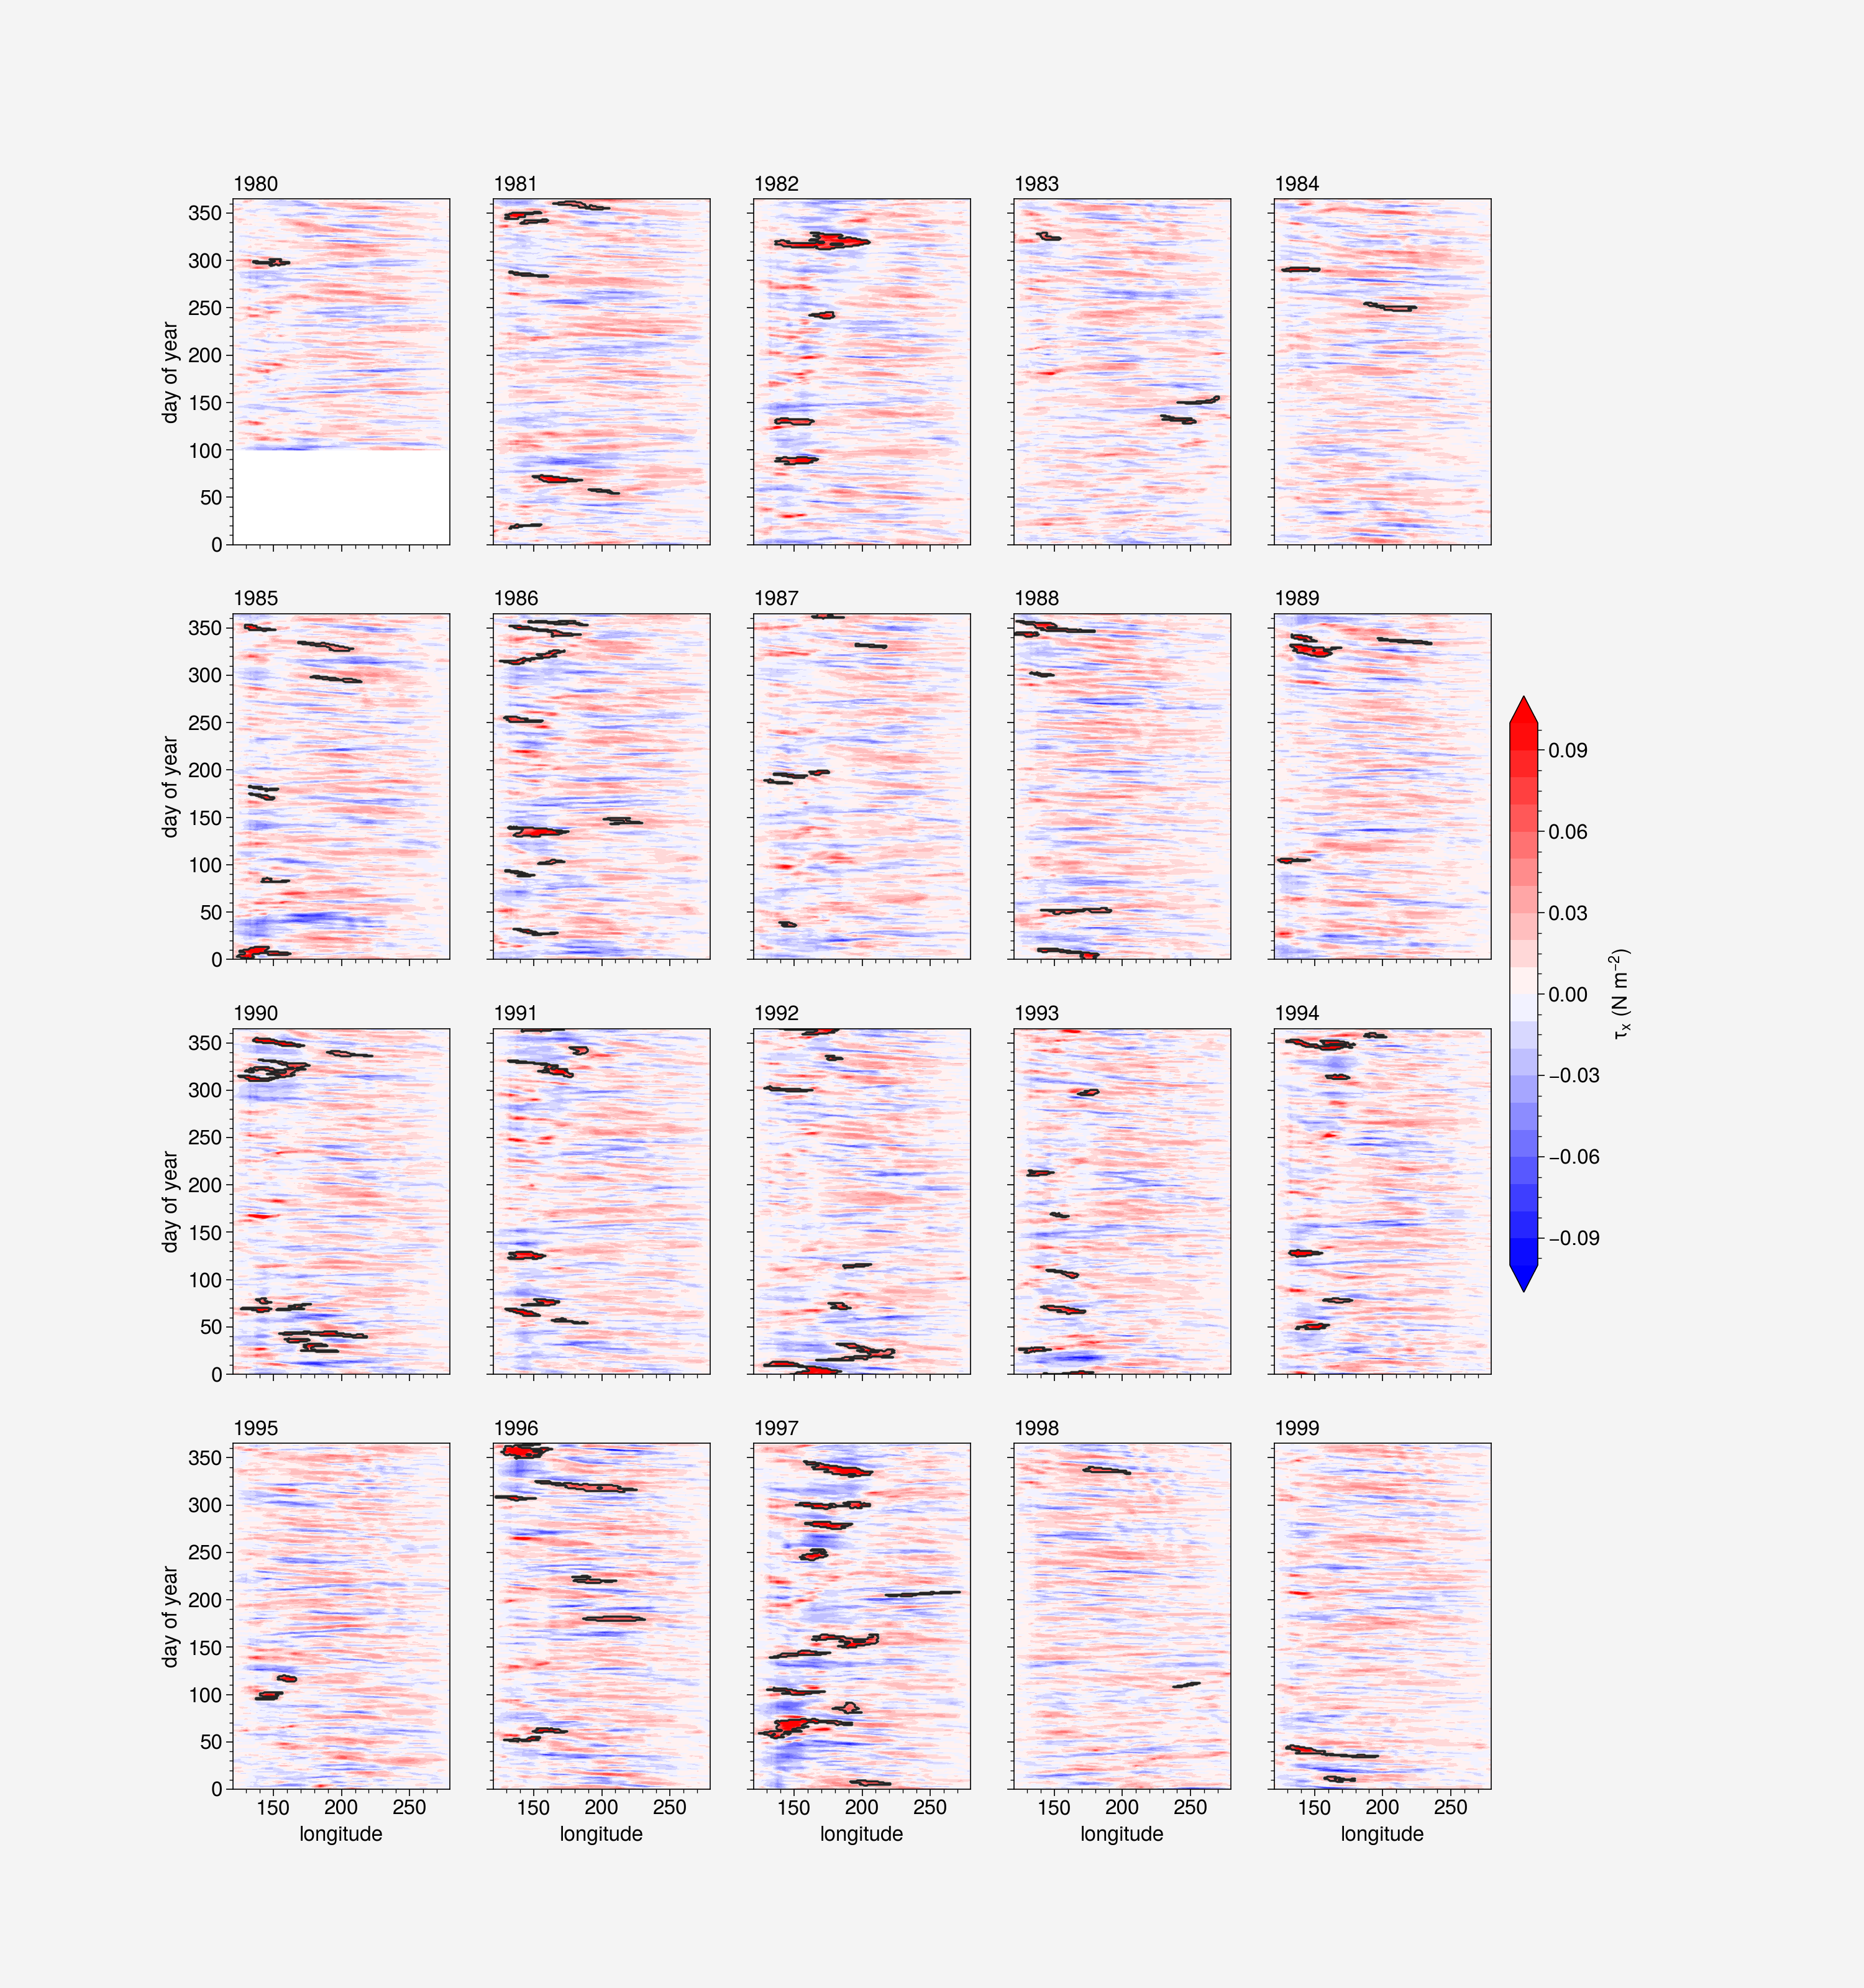

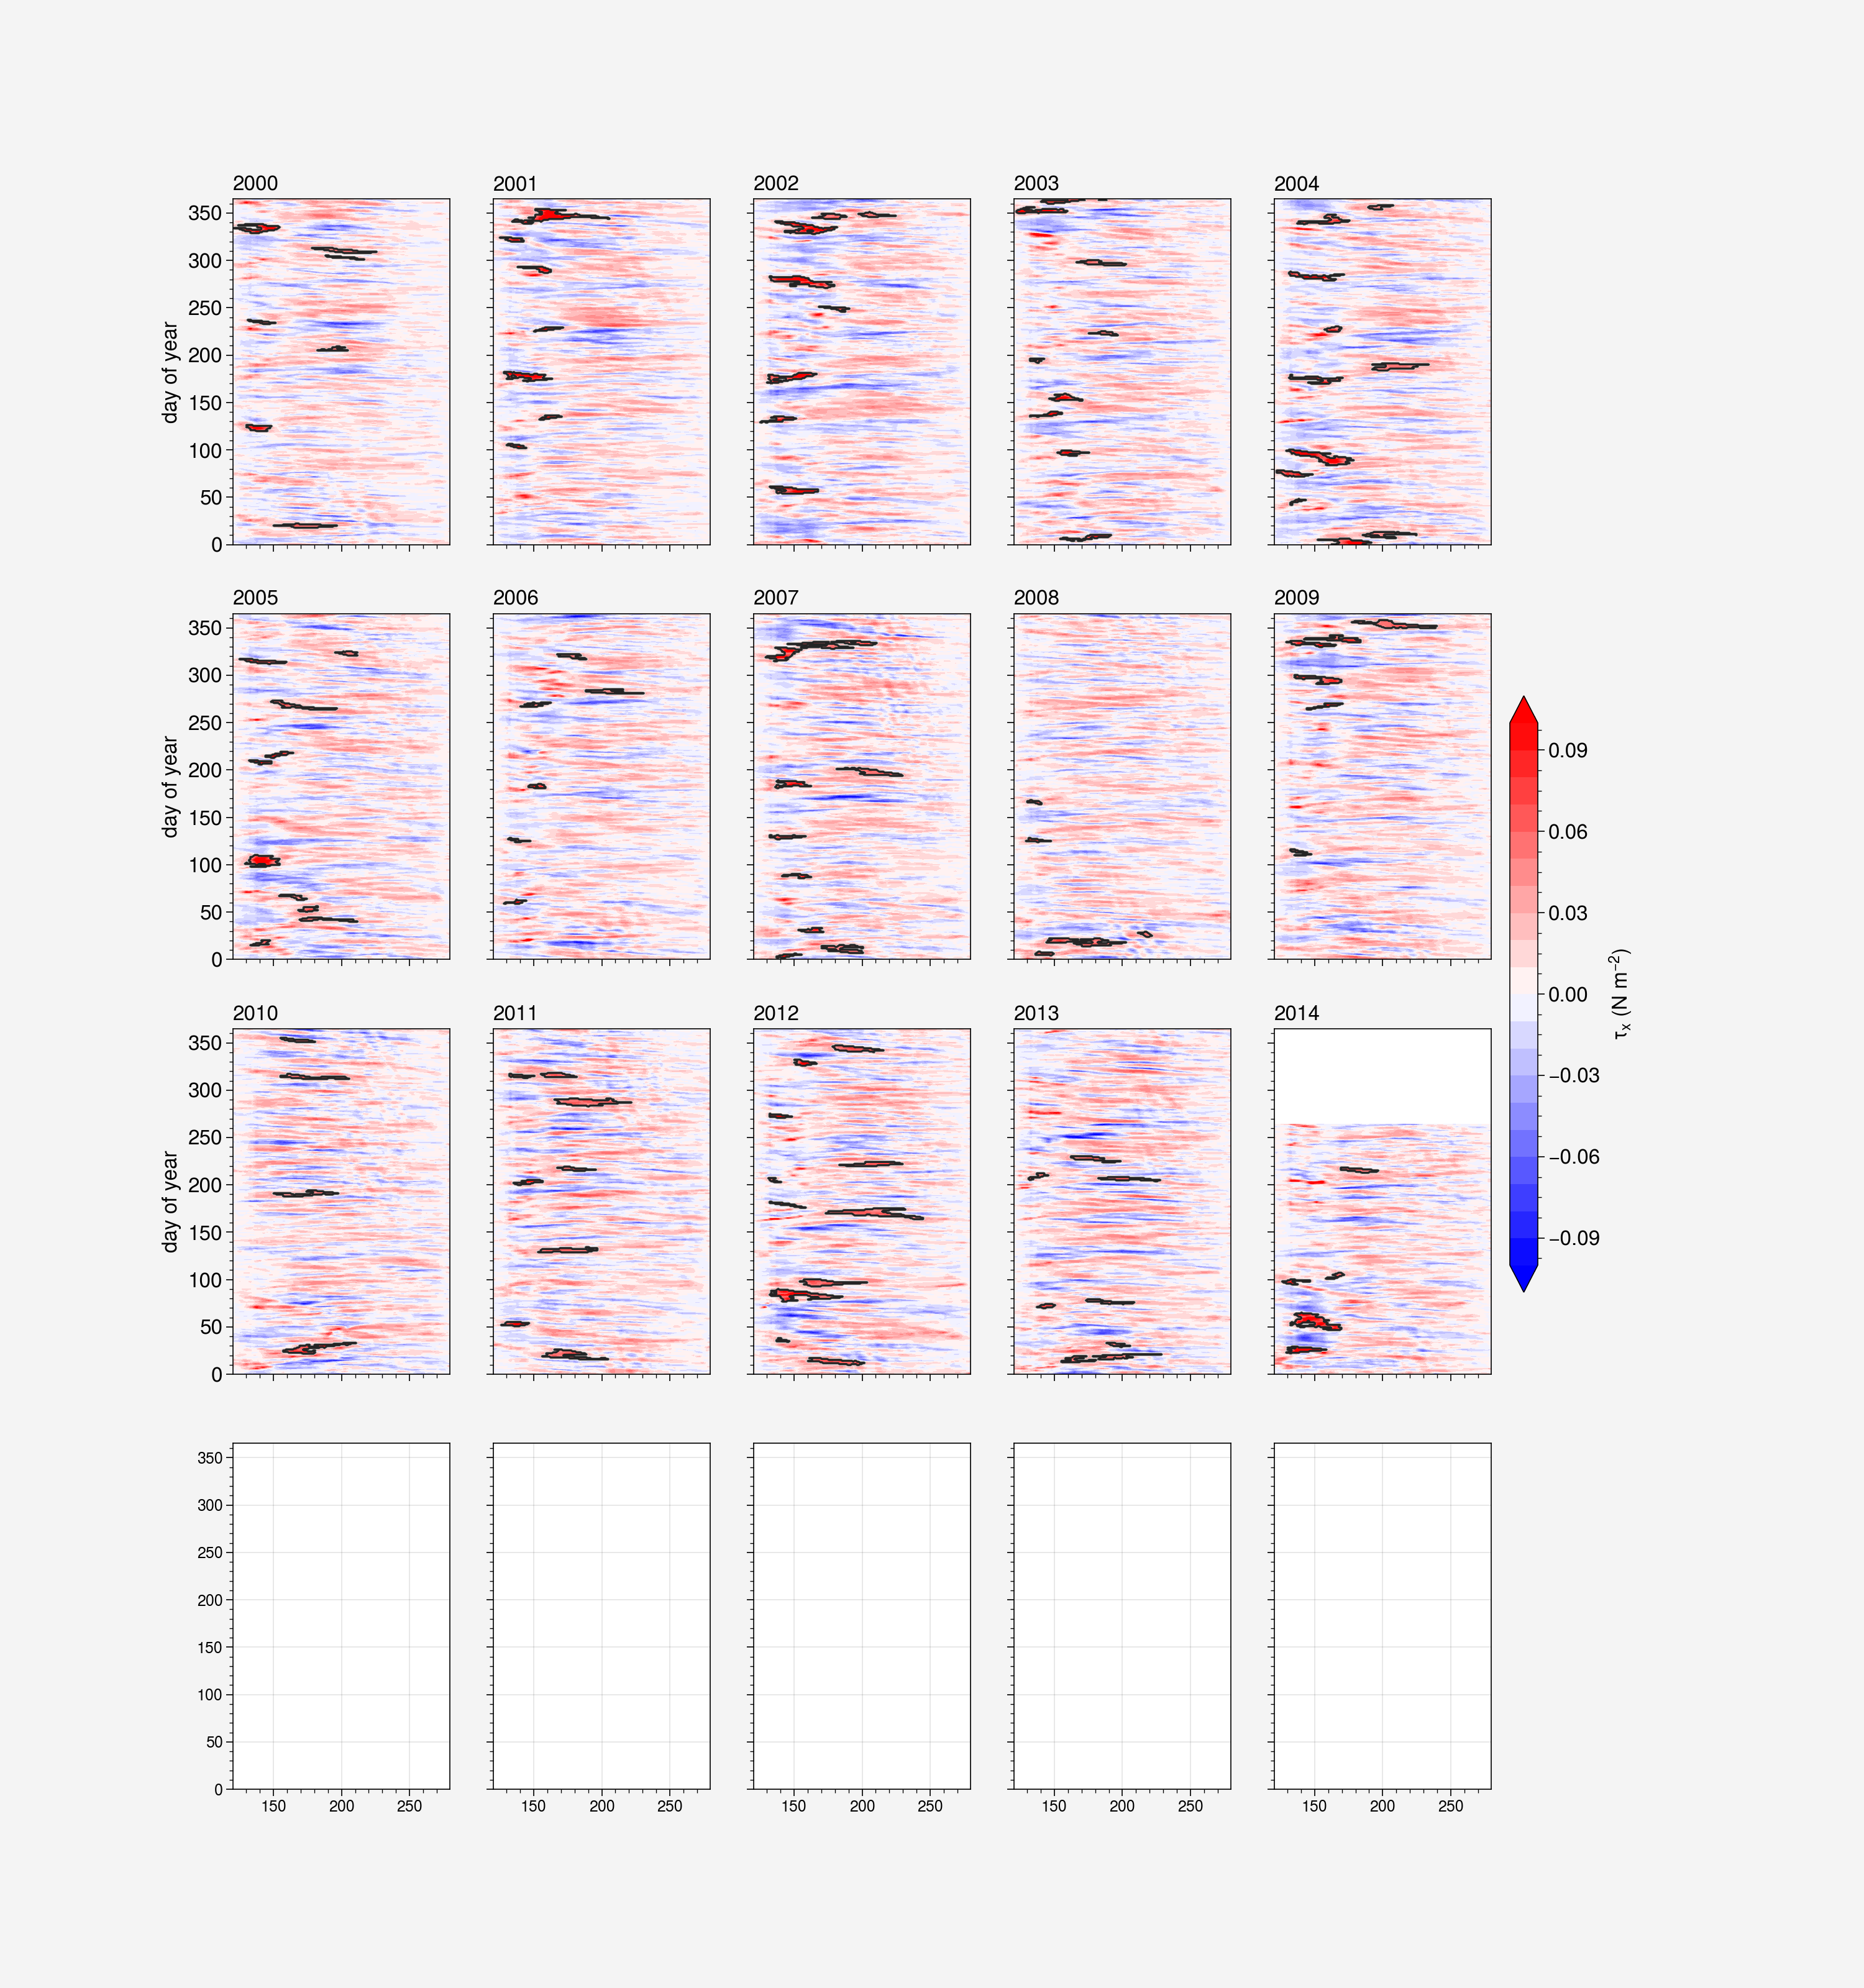

In [13]:
#plot_model_Hovmollers_by_year(data = obs_data, tauu_time = obs_time)

plot_model_Hovmollers_by_year(data = obs_data, wwe_mask = wwe_mask, lon_vals = obs_lon_vals,
                                  tauu_time = obs_time, savename = 'test',
                                  first_year = '1980', last_year = '2014')

In [25]:
filt_descrip = '120-day highpass filtered'
save_name = 'TropFlux_120-dayHPfiltered_tauu_1980-2014'
data_vars = dict(
        WWEs_per_lon  =(['Pac_lon'], obs_count_event_lons[0], dict(units='None', long_name='Count of unique WWEs affecting each 1° longitude bin')),
        filtered_tauu =(['time', 'Pac_lon'], obs_data.squeeze(), dict(units='Pa', long_name = filt_descrip + ' zonal wind stress')),
        WWE_mask      =(['time', 'Pac_lon'], wwe_mask, dict(units='binary', lon_name = 'Ones where WWEs are, zeros otherwise')),
        TropFlux_lons =(['lon'], np.asarray(ws_lon_vals), dict(units='degrees East', long_name = 'Longitude')),
        TropFlux_lats =(['lat'], np.asarray(ws_lat_vals), dict(units='degrees North', longname = 'Latitude'))
    )

ds = xr.Dataset(data_vars = data_vars,
                coords=dict(
                    Pac_lon= obs_lon_vals,
                    time   = obs_time,
                    lon    = np.asarray(ws_lon_vals),
                    lat    = np.asarray(ws_lat_vals)
                ),
                attrs=dict(description= filt_descrip + " zonal wind stress and WWEs per longitude. Generated using MDTF POD WWE diagnostic")
               )

ds.to_netcdf(save_name + '.nc')
    